# MCMC CALIBRATION TECHNICS IN CONTEXT OF  INFECTIOUS DISEASE MODELING

## Prerequies

In [ ]:
# pip install summerepi2 estival jax==0.4.24 jaxlib==0.4.24 nevergrad jupyter pymc numpyro

In [ ]:
# pip install multiprocess
# %pip install --upgrade --force-reinstall multiprocess


In [14]:
# This is required for pymc parallel evaluation in notebooks

import multiprocess as mp
import platform

if platform.system() != "Windows":
    
    mp.set_start_method('forkserver')

In [2]:
import Calibrate as cal #Runing the calibration process and gathering results
from calibs_utilities import get_all_priors, get_targets, load_data
from models.models import model1 #All the models we design for the test
from Calibrate import plot_comparison_bars

# Combining tagets and prior with our summer2 model in a BayesianCompartmentalModel (BCM)
from estival.model import BayesianCompartmentalModel


import pandas as pd
import numpy as np
import plotly.express as px
import matplotlib.pyplot as plt
from typing import List

import pymc as pm

# We use estivals parallel tools to run the model evaluations
from estival.utils.parallel import map_parallel


WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


## Calibration Data
If data are needed to define a target, we just need to import it from our file data which we will design correctly.
In this example we import data from a YAML file.

In [7]:
#An example of data for the calibration 
pd.options.plotting.backend = "plotly" #To allow plotly graphic. Swich to "matplotlib" if facing some troubles while ploting

output_labels = {"index": "time", "value": "number infectious"}

targets_yml = './data/target_yml.yml'
targets = load_data(targets_yml)
targets_data = targets['active_cases']

targets_data.plot(kind="scatter",labels=output_labels)



In [8]:
#Names of parameters and their ranges
params = {
    "contact_rate": (0.0,0.5),
    "recovery_rate": (0.0,0.8)

}
params
targets = get_targets(targets_yml)
priors = get_all_priors(params)

## Model Definition and Configuration

A mechanistic model (ODE-Based) model discribing Infectious Disease transmission.

In [9]:
model_1 = model1()

## Trial run 

In [10]:
parameters = {
    "contact_rate": 0.2,
    "recovery_rate": 0.1,
    #"active_cases_dispersion": 0.5,
}

model_1.run(parameters)


pd.DataFrame(
    {
        "modelled": model_1.get_outputs_df()["infectious"],
        "observed": targets_data,
    }
).plot(kind="scatter", labels=output_labels)

## Sampling 

In [11]:
#Defining  a Bayesian Compartmental Model
bcm = BayesianCompartmentalModel(model_1, parameters, priors, targets)

In [12]:
initial_parameters = {
"contact_rate": 0.15,
"recovery_rate": 0.1,
#"active_cases_dispersion": (0.5,1),
}



In [16]:
D = 2 # Dimension of the parameter's space
samplers = [pm.DEMetropolisZ]*2 + [pm.DEMetropolis]*2 + [pm.Metropolis]*4
Draws = [4000]*6+ [8000]*2
Tunes = [100] + [1000] + [100] + [1000] + [100] + [1000] + [100] + [1000]
chains = 2*D
results = []
for sampler, draws, tune in zip (samplers, Draws, Tunes):
    #print(sampler)
    idata, Time = cal.Sampling_calib(
        bcm_model = bcm,
        mcmc_algo = sampler,
        initial_params = initial_parameters,
        draws = draws,
        tune = tune,
        cores = 4,
        chains = chains,
        )

    results.append(cal.Compute_metrics(
        mcmc_algo = sampler,
        idata = idata,
        Time = Time,
        draws = draws, 
        chains = chains,
        tune = tune,
            )
        )


Multiprocess sampling (4 chains in 4 jobs)
DEMetropolisZ: [contact_rate, recovery_rate]
Sampling 4 chains for 100 tune and 4_000 draw iterations (400 + 16_000 draws total) took 29 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
Multiprocess sampling (4 chains in 4 jobs)
DEMetropolisZ: [contact_rate, recovery_rate]
Sampling 4 chains for 1_000 tune and 4_000 draw iterations (4_000 + 16_000 draws total) took 29 seconds.
Population sampling (4 chains)
DEMetropolis: [contact_rate, recovery_rate]
Attempting to parallelize chains to all cores. You can turn this off with `pm.sample(cores=1)`.
Sampling 4 chains for 100 tune and 4_000 draw iterations (400 + 16_000 draws total) took 26 seconds.
The 

In [17]:
#results_df.drop(results_df.index, inplace=True)

results_df = pd.concat(results)
results_df["Run"] = results_df.Sampler + "\nDraws=" + results_df.Chains.astype(str) + "\nTune=" + results_df.Tune.astype(str)

results_df = results_df.reset_index(drop=True)
results_df.style.set_caption("MCMC COMPARISON")
# print(results_df.Sampler)

,Sampler,Draws,Chains,Tune,Time,Mean_ESS,Min_Ess,Ess_per_sec,Mean_Rhat,Rhat_max,Trace,Run
0,DEMetropolisZ,4000,4,100,32.007483,48.259986,44.243929,1.507772,1.582551,1.632739,Inference data with groups: > posterior > sample_stats,DEMetropolisZ Draws=4 Tune=100
1,DEMetropolisZ,4000,4,1000,32.514029,948.192919,941.917810,29.162578,1.007074,1.007844,Inference data with groups: > posterior > sample_stats,DEMetropolisZ Draws=4 Tune=1000
2,DEMetropolis,4000,4,100,29.446568,13.753149,11.264330,0.467054,1.442003,1.479775,Inference data with groups: > posterior > sample_stats,DEMetropolis Draws=4 Tune=100
3,DEMetropolis,4000,4,1000,31.469551,925.873290,915.041921,29.421242,1.003271,1.003297,Inference data with groups: > posterior > sample_stats,DEMetropolis Draws=4 Tune=1000
4,metropolis,4000,4,100,32.937598,5.400294,5.346020,0.163955,1.995948,2.027464,Inference data with groups: > posterior > sample_stats,metropolis Draws=4 Tune=100
5,metropolis,4000,4,1000,34.933960,5.057356,5.054791,0.144769,2.215547,2.217268,Inference data with groups: > posterior > sample_stats,metropolis Draws=4 Tune=1000
6,metropolis,8000,4,100,41.217403,5.756403,5.747732,0.139660,1.846370,1.851223,Inference data with groups: > posterior > sample_stats,metropolis Draws=4 Tune=100
7,metropolis,8000,4,1000,42.732143,5.384769,5.327123,0.126012,2.004795,2.034744,Inference data with groups: > posterior > sample_stats,metropolis Draws=4 Tune=1000


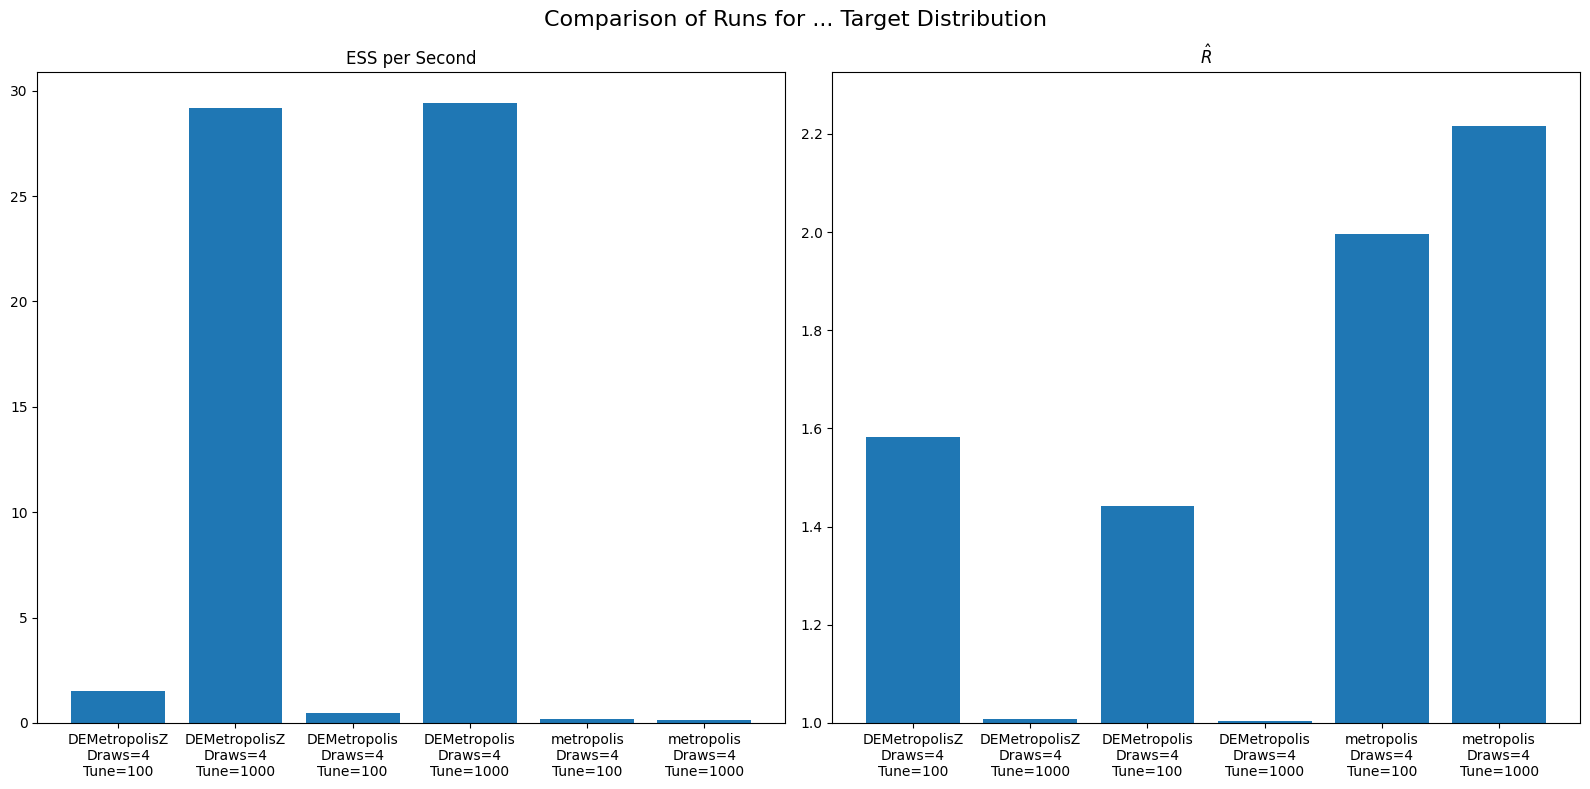

In [20]:
plot_comparison_bars(results_df=results_df)


## Using arviz for trace visualization

Run =  DEMetropolisZ
Draws=4
Tune=100


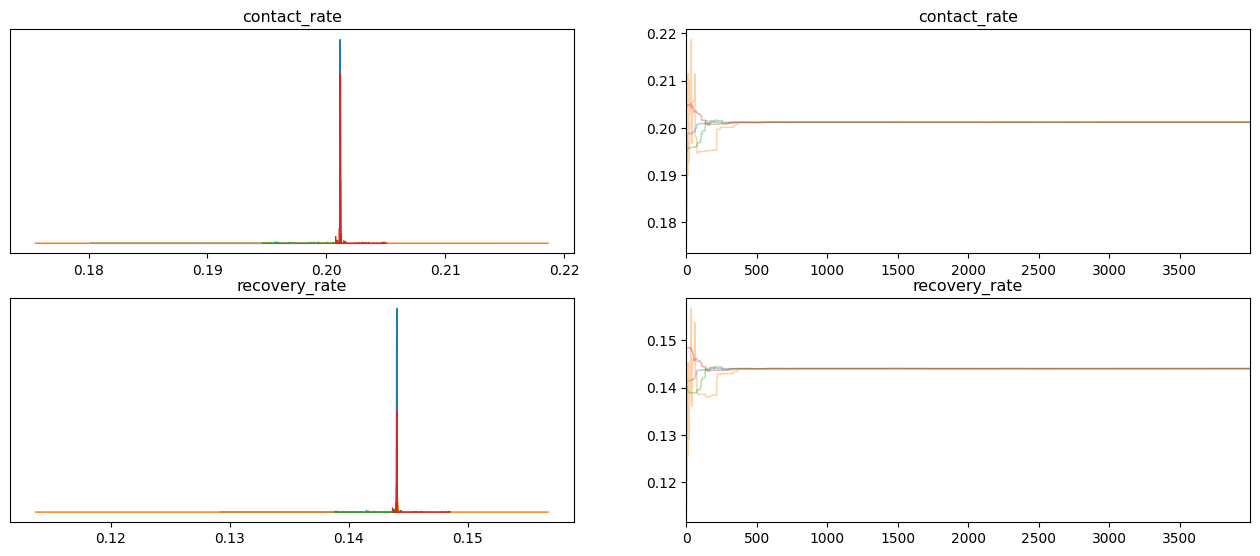

Run =  DEMetropolisZ
Draws=4
Tune=1000


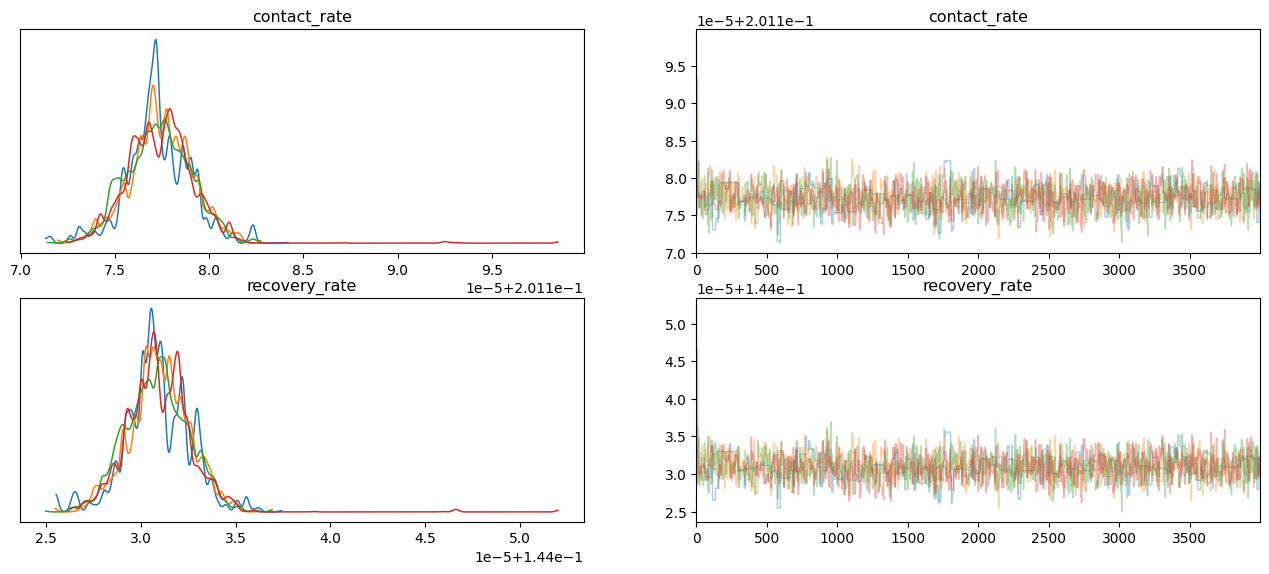

Run =  DEMetropolis
Draws=4
Tune=100


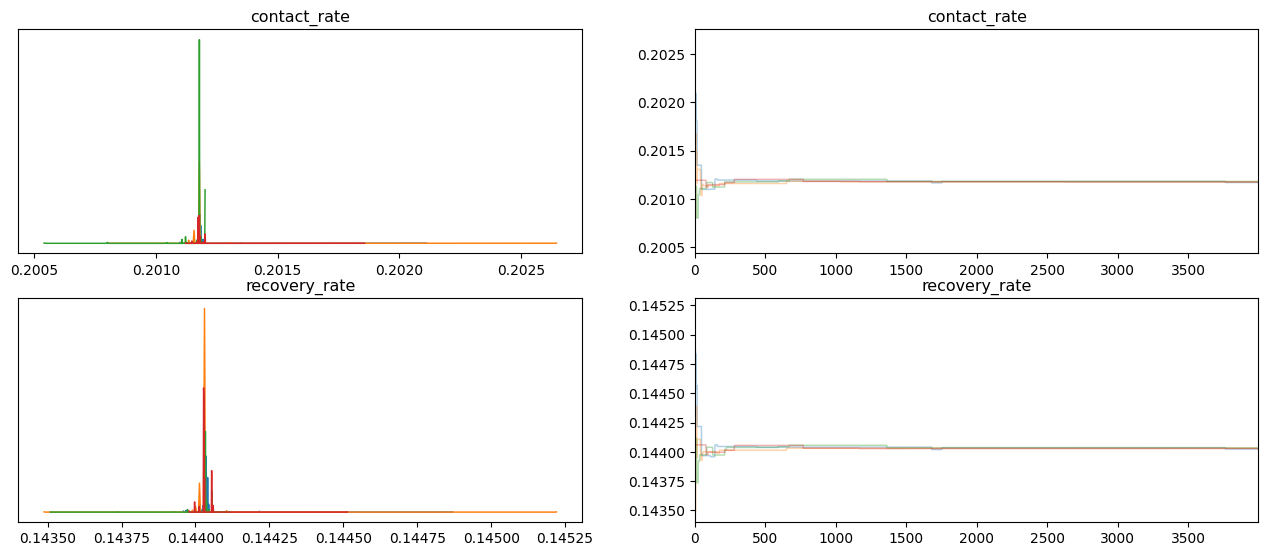

Run =  DEMetropolis
Draws=4
Tune=1000


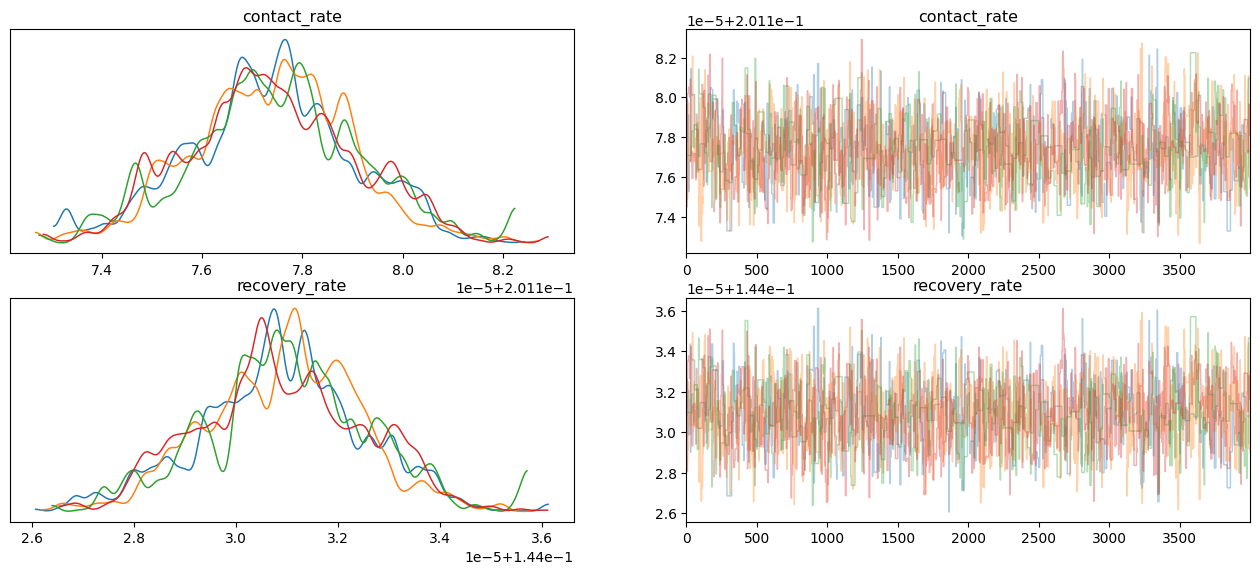

Run =  metropolis
Draws=4
Tune=100


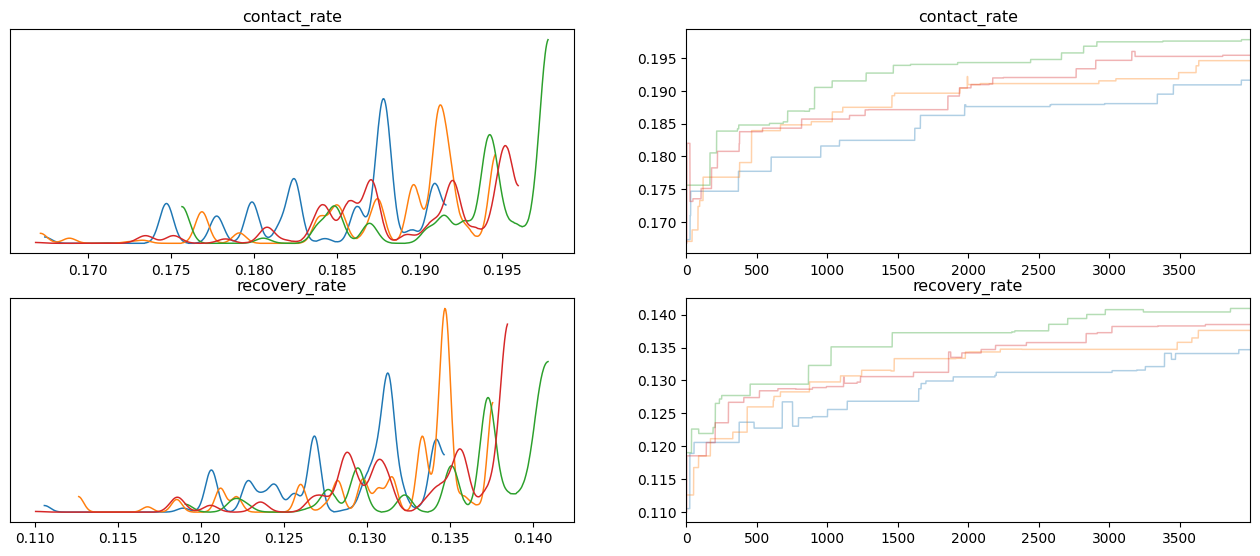

Run =  metropolis
Draws=4
Tune=1000


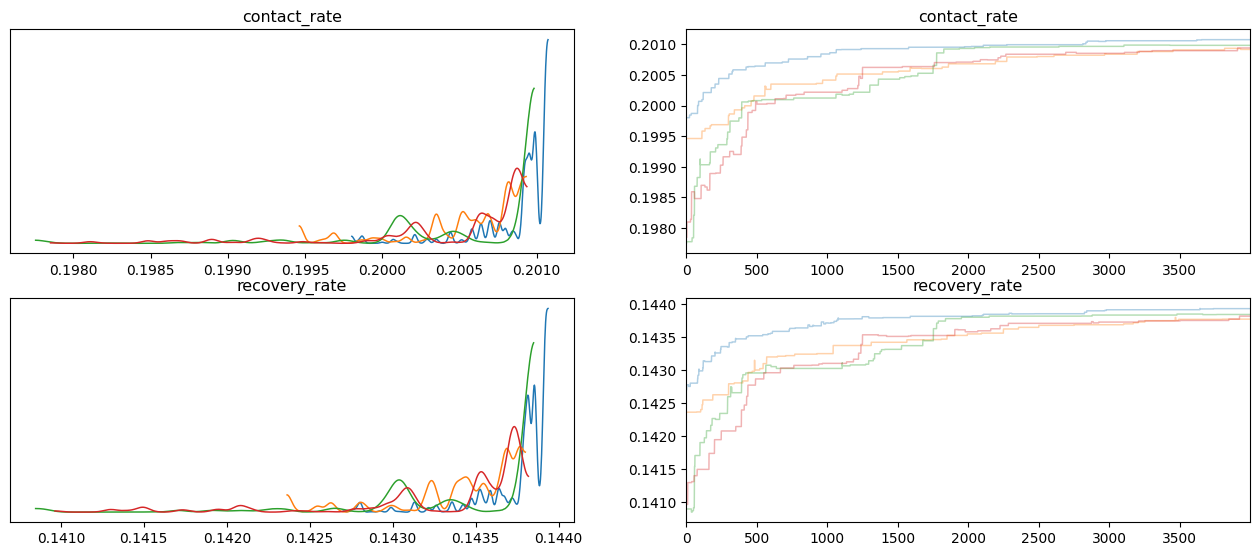

Run =  metropolis
Draws=4
Tune=100


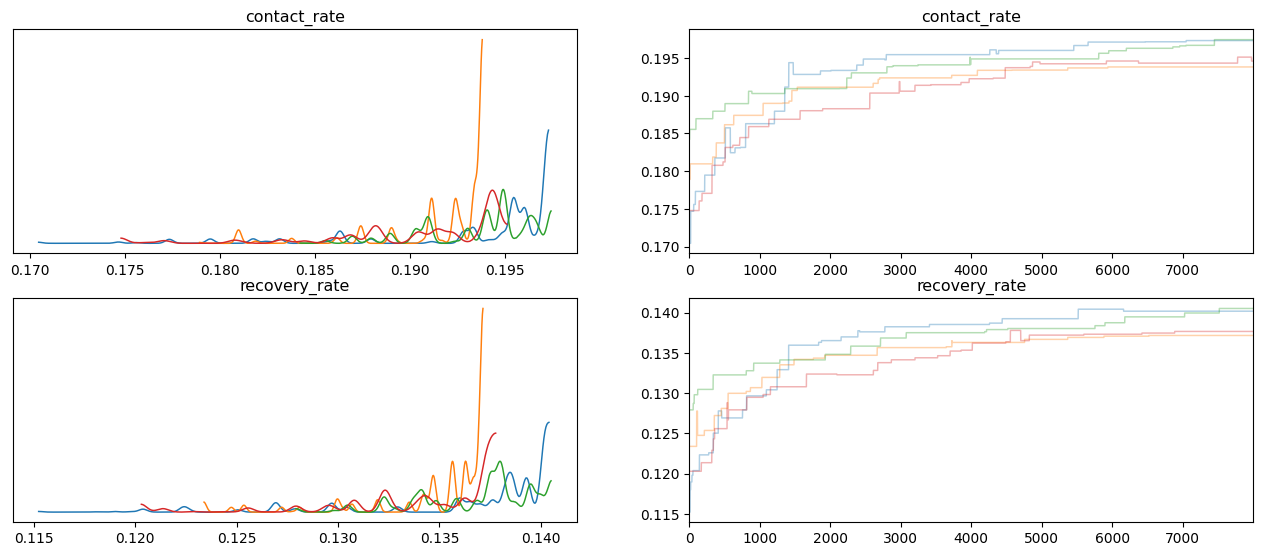

Run =  metropolis
Draws=4
Tune=1000


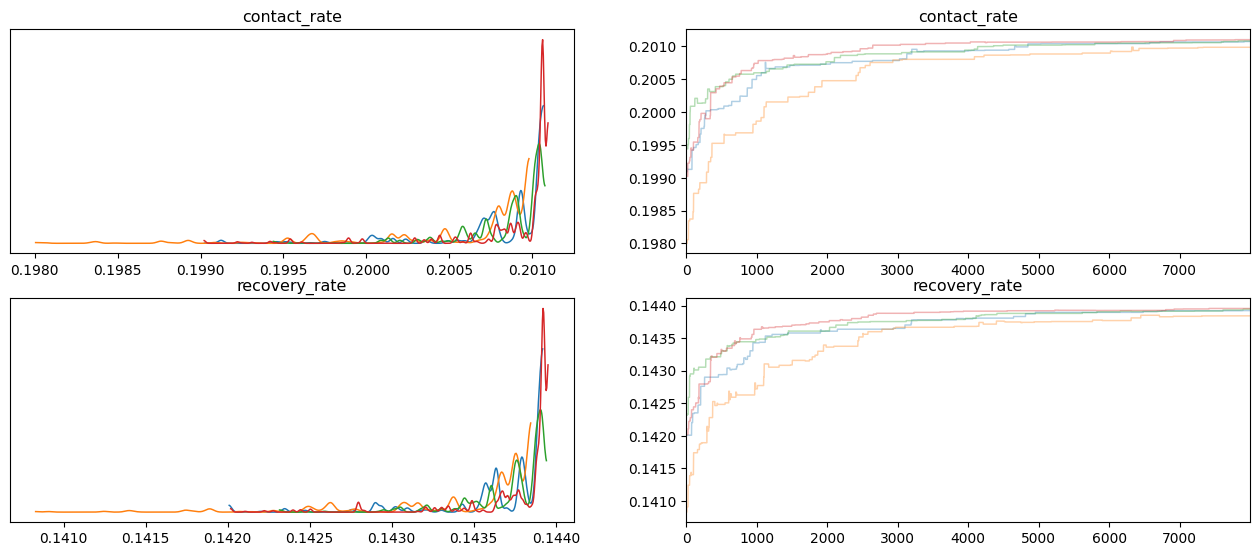

In [21]:
import arviz as az
for idata, Run, draws, tune in zip(results_df.Trace, results_df.Run, results_df.Draws, results_df.Tune):
    subset = idata.sel(draw=slice(0, None), groups="posterior")
    print("Run = ",Run)
    az.plot_trace(subset, figsize=(16,3.2*len(subset.posterior)),compact=False)#, lines=[("m", {}, mtrue), ("c", {}, ctrue)]);
    plt.show()



In [22]:
from estival.sampling.tools import likelihood_extras_for_idata
from estival.sampling import tools as esamptools

## Computing the likelihood function for each sampler

In [ ]:
from estival.model.base import ResultsData

In [ ]:
map_res : List[ResultsData]
targets_datas = pd.DataFrame(targets_data)

targets_datas.values

In [ ]:
#i=0 
#pd.options.plotting.backend = "matplotlib"
#map_res = np.zeros(8, dtype=ResultsData) #To specify the type of the elements in the list, default is tuple
map_res : List[ResultsData]
map_params = []
for idata, sampler ,run in zip(results_df.Trace, results_df.Sampler, results_df.Run):
    if (sampler == "metropolis"): #Because pm.metropolis is not compatible directly with the likelihood function from est.samp.tools
        # print(sampler)
       likelihood_df = esamptools.likelihood_extras_for_samples(idata.posterior, bcm)

    else :
        likelihood_df = likelihood_extras_for_idata(idata, bcm)
    ldf_sorted = likelihood_df.sort_values(by="logposterior",ascending=False)
    map_parameter = idata.posterior.to_dataframe().loc[ldf_sorted.index[0]].to_dict()
    print(idata.posterior.to_dataframe().loc[ldf_sorted.index[0]])

    map_params.append(map_parameter)
    map_res.append(bcm.run(map_parameter))
    # res = bcm.run(map_parameter)
    # output = res.derived_outputs["active_cases"]

    # ax = pd.DataFrame(
    #     {
    #         f"{run}": output,
    #         "Observed" : targets_datas,
    #     }
    # ).plot(kind="scatter", x=targets_datas.index, y=targets_datas.values, labels=output_labels)
    # plt.show()
    #map_res[i] = bcm.run(map_parameter)
    #i+=1
        



In [ ]:
for res in zip (map_res):
    res

res[0].derived_outputs["active_cases"]

In [ ]:
dfs = []

for sampler, res, draws in zip(results_df.Sampler, map_res, results_df.Draws):
    res = res[0]
    ax = pd.DataFrame(
        {
            f"{sampler}, draws = {draws}": res.derived_outputs["active_cases"],
            "Observed" : targets_data,
        }
    ).plot(kind="scatter", labels=output_labels)
   
    
    plt.show()

#    comb_df = pd.concat(dfs, axis=1)

#    comb_df.plot(kind="scatter", labels=output_labels)
# comb_df

In [ ]:
# model_1.run(map_params)
"""
pd.DataFrame(
    {
        "DEMetropolisZ": map_res[0].derived_outputs["active_cases"],
        "DEMetropolis": map_res[1].derived_outputs["active_cases"],
        "Metropolis": map_res[2].derived_outputs["active_cases"],
        f"Metropolis, draws": map_res[3].derived_outputs["active_cases"],


        "observed": targets_data,
    }
).plot(kind="scatter", labels=output_labels)
"""


## Uncertainty sampling

In [ ]:
# Use the arviz extract method to obtain some samples, then convert to a DataFrame
sample_idata = az.extract(idata, num_samples=4000)
samples_df = sample_idata.to_dataframe().drop(columns=["chain","draw"])


In [ ]:
idata

In [ ]:
# Wrapper function captures our bcm from the main namespace to pass into map_parallel
# Using this idiom in closures/factory functions is typical
def run_sample(idx_sample):
    idx, params = idx_sample
    return idx, bcm.run(params)

# Run the samples through our BCM using the above function
# map_parallel takes a function and an iterable as input

# We use 4 workers here, default is cpu_count/2 (assumes hyperthreading)
sample_res = map_parallel(run_sample, samples_df.iterrows(), n_workers=4)


In [ ]:
sample_res

In [ ]:
# We'll use xarray for this step; aside from computing things very quickly, it's useful
# to persist the run results to netcdf/zarr etc

import xarray as xr

In [ ]:
# Build a DataArray out of our results, then assign coords for indexing
xres = xr.DataArray(np.stack([r.derived_outputs for idx, r in sample_res]), 
                    dims=["sample","time","variable"])
xres = xres.assign_coords(sample=sample_idata.coords["sample"], 
                          time=map_res[-1].derived_outputs.index, variable=map_res[-1].derived_outputs.columns)

In [ ]:
# Set some quantiles to calculate
quantiles = (0.25,0.5,0.75,0.80,0.95)

# Generate a new DataArray containing the quantiles
xquantiles = xres.quantile(quantiles,dim=["sample"])

In [ ]:
# Extract these values to a pandas DataFrame for ease of plotting

uncertainty_df = xquantiles.to_dataframe(name="value").reset_index().set_index("time").pivot(columns=("variable","quantile"))["value"]

In [ ]:
variable = "active_cases"

fig = uncertainty_df[variable].plot(title=variable,alpha=0.7)
pd.Series(map_res[-1].derived_outputs[variable]).plot(style='--')
bcm.targets[variable].data.plot(style='.',color="black", ms=5, alpha=0.8)

## Analysing the posterior likelihood landscape analysis using ELA

In [ ]:
# !pip install pflacco
from pflacco.classical_ela_features import *
from pflacco.local_optima_network_features import compute_local_optima_network, calculate_lon_features
#__To___create_a_initial____sample
from pflacco.sampling import create_initial_sample